# Initialized Gradient Boosted Regression Trees

Выполнил Михаил Притугин BD-31 - вариант 16

# Построение дерева решений

def build(L):

    create node t
    
    if the stopping criterion is True:
    
        assign a predictive model to t
        
    else:
    
        Find the best binary split L = L_left + L_right
        
        t.left = build(L_left)
        
        t.right = build(L_right)
        
    return t 

Для задачи регрессии в качестве меры неопределенности могут выступать

* Среднее квадратичное отклонение от среднего
$$ I(S) = \frac{1}{|S|}\sum\limits_{i \in S}(y_i - \bar{y_S})^2 $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline

/Users/m.pritugin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class DecisionTree:
    """
        author: Michael Pritugin
    """
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, max_depth=None, min_samples_split=2, max_features=None, min_samples_leaf=1):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise
            
    def set_params(self, **params):
        self.max_depth = params.get("max_depth")
        self.max_features = params.get("max_features")
        self.min_samples_split = params.get("min_samples_split", 2)
        self.min_samples_leaf = params.get("min_samples_leaf", 1)
        return self
        
    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "max_features": self.max_features,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }      
            
            
    def __repr__(self):
        return f"DecisionTree(min_samples_split={self.min_samples_split}, max_depth={self.max_depth}, \
max_features={self.max_features}, min_samples_leaf={self.min_samples_leaf})"
    
    def __str__(self):
        return f"DecisionTree(min_samples_split={self.min_samples_split}, max_depth={self.max_depth}, \
max_features={self.max_features}, min_samples_leaf={self.min_samples_leaf})"
    
    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return np.array(feature_ids[: max(1, np.int(np.log2(n_feature)))])

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return np.array(feature_ids[: max(1, np.int(np.sqrt(n_feature)))])

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)
    
    @staticmethod
    def _sort_samples(x, y):
        sorted_idx = x.argsort(axis=0)
        return np.sort(x, axis=0), y[sorted_idx]
    
    @staticmethod
    def _div_samples(x, y, feature_id, threshold):
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __fit_node(self, x, y, node_id, depth):
        if (x.shape[0] < self.min_samples_split) or (depth == self.max_depth):
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
            return

        sortX, sortY = DecisionTree._sort_samples(x, y)

        cumsumY2 = np.cumsum(sortY ** 2, axis=0)
        cumsumRevY2 = np.cumsum(sortY[::-1] ** 2, axis=0)[::-1]

        cumsumY = np.cumsum(sortY, axis=0)
        cumsumRevY = np.cumsum(sortY[::-1], axis=0)[::-1]

        lenArray = np.array(range(1, cumsumY.shape[0] + 1)).reshape(-1, 1)
        left = cumsumY2 - cumsumY ** 2 / lenArray
        right = cumsumRevY2 - cumsumRevY ** 2 / lenArray[::-1]

        mse = left
        mse[:-1] += right[1:]
        
        # удаляем бесполезные фичи
        bad_features = np.where((np.max(x, axis=0) - np.min(x, axis=0)) < 1e-3)[0]
        mse[:, bad_features] = np.nan
        # если две фичи рядом очень похожи между собой, то надо выкинуть фичу -> пропускаем очень близкие значения
        # np.isclose - возвращает логический массив, где два массива поэлементно равны в пределах допуска
        mse[np.isclose(sortX, np.roll(sortX, shift=-1, axis=0))] = np.nan
        # если ошибка - значит топ сплита нет - и мы переобучимся - делаем резкий 
        
        try:
            argmin = np.nanargmin(mse)
        except ValueError:
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
            return
        
        # получаем номер объекта и фичу лучшего сплита
        idx = argmin // mse.shape[1]
        feature_id = argmin - idx*mse.shape[1]
        
        threshold = sortX[idx, feature_id]
        # логика построения дерева
        Xleft, Xright, Yleft, Yright = self._div_samples(x, y, feature_id, threshold)

        if Xleft.shape[0] < self.min_samples_leaf or Xright.shape[0] < self.min_samples_leaf:
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
        else:
            self.tree[node_id] = self.NON_LEAF_TYPE, feature_id, threshold
            
            self.__fit_node(Xleft, Yleft, 2 * node_id + 1, depth + 1)
            self.__fit_node(Xright, Yright, 2 * node_id + 2, depth + 1)

    def fit(self, X, y):
        self.features = self.get_feature_ids(X.shape[1])
        self.__fit_node(X[:, self.features], y, 0, 0)
        return self

    def __predict(self, x, node_id):
        node = self.tree[node_id]
        answer = np.zeros(x.shape[0])
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            left_idx = np.where(x[:, feature_id] <= threshold)
            right_idx = np.where(x[:, feature_id] > threshold)

            answer[left_idx] = self.__predict(x[left_idx], 2*node_id + 1)
            answer[right_idx] = self.__predict(x[right_idx], 2*node_id + 2)
            return answer
        
        
        return np.array([node[1]]*x.shape[0])
            
    def predict(self, X):
        x = X[:, self.features]
        answer = self.__predict(X, 0)
        return answer

## Тестирование

In [3]:
myclf = DecisionTree(max_depth=7)
clf = DecisionTreeRegressor(max_depth=7)

In [4]:
X, y = datasets.load_boston(return_X_y=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [6]:
%time myclf.fit(X_train, y_train)

CPU times: user 18.1 ms, sys: 1.78 ms, total: 19.9 ms
Wall time: 19.8 ms


DecisionTree(min_samples_split=2, max_depth=7, max_features=None, min_samples_leaf=1)

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 1.99 ms, sys: 1.17 ms, total: 3.16 ms
Wall time: 2.7 ms


DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Train

In [8]:
my_pred = myclf.predict(X_train)
pred = clf.predict(X_train)

In [9]:
print(f"MSE Моего Дерева на трейне = {mean_squared_error(y_train, my_pred)}")

MSE Моего Дерева на трейне = 2.8931871119750414


In [10]:
print(f"MSE Sklearn Дерева на трейне = {mean_squared_error(y_train, pred)}")

MSE Sklearn Дерева на трейне = 2.8931871119750414


In [11]:
print(f"MSE Среднего предсказания на трейне = {mean_squared_error(y_train, np.array([y_train.mean()]*len(y_train)))}")

MSE Среднего предсказания на трейне = 89.20835426673854


### Test

In [12]:
my_pred = myclf.predict(X_test)
pred = clf.predict(X_test)

In [13]:
print(f"MSE Моего Дерева на тесте = {mean_squared_error(y_test, my_pred)}")

MSE Моего Дерева на тесте = 17.90999374173111


In [14]:
print(f"MSE Sklearn Дерева на тесте = {mean_squared_error(y_test, pred)}")

MSE Sklearn Дерева на тесте = 19.603636677362157


In [15]:
print(f"MSE Среднего предсказания на тесте = {mean_squared_error(y_test, np.array([y_test.mean()]*len(y_test)))}")

MSE Среднего предсказания на тесте = 64.40543733179547


# RandomForest

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
class RandomForest:
    """
        author: Michael Pritugin
    """
    def __init__(self, n_estimators: int=20, max_depth=None,
                    min_samples_split: int=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = []
        
    def set_params(self, **params):
        self.n_estimators = params.get("n_estimators", 20)
        self.max_depth = params.get("max_depth")
        self.min_samples_split = params.get("min_samples_split", 2)
        self.min_samples_leaf = params.get("min_samples_leaf", 1)
        return self
        
    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }  
            
            
    def __repr__(self):
        return f"RandomForest(n_estimators={self.n_estimators}, max_depth={self.max_depth}, \
min_samples_split={self.min_samples_split}, min_samples_leaf={self.min_samples_leaf})"
    
    def __str__(self):
        return f"RandomForest(n_estimators={self.n_estimators}, max_depth={self.max_depth}, \
min_samples_split={self.min_samples_split}, min_samples_leaf={self.min_samples_leaf})"
    
    def fit(self, X, y):
        for _ in range(self.n_estimators):
            indices = np.random.randint(0, X.shape[0], X.shape[0])
            new_model = DecisionTree(min_samples_split=self.min_samples_split,
                                      max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            new_model.fit(X[indices], y[indices])
            self.models.append(new_model)
        return self

    def predict(self, X):
        answer = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            answer += self.models[i].predict(X)
        return answer / self.n_estimators

## Тестирование

In [18]:
myclf = RandomForest(max_depth=7)
clf = RandomForestRegressor(max_depth=7)

In [19]:
myclf.fit(X_train, y_train)

RandomForest(n_estimators=20, max_depth=7, min_samples_split=2, min_samples_leaf=1)

In [20]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Train

In [21]:
my_pred = myclf.predict(X_train)
pred = clf.predict(X_train)

In [22]:
print(f"MSE Моего RandomForest на трейне = {mean_squared_error(y_train, my_pred)}")

MSE Моего RandomForest на трейне = 2.859091837754958


In [23]:
print(f"MSE Sklearn RandomForest на трейне = {mean_squared_error(y_train, pred)}")

MSE Sklearn RandomForest на трейне = 3.2183821925080247


In [24]:
print(f"MSE Среднего предсказания на трейне = {mean_squared_error(y_train, np.array([y_train.mean()]*len(y_train)))}")

MSE Среднего предсказания на трейне = 89.20835426673854


### Test

In [25]:
my_pred = myclf.predict(X_test)
pred = clf.predict(X_test)

In [26]:
print(f"MSE Моего RandomForest на трейне = {mean_squared_error(y_test, my_pred)}")

MSE Моего RandomForest на трейне = 11.921884363862018


In [27]:
print(f"MSE Sklearn RandomForest на тесте = {mean_squared_error(y_test, pred)}")

MSE Sklearn RandomForest на тесте = 15.623305495738414


In [28]:
print(f"MSE Среднего предсказания на тесте = {mean_squared_error(y_test, np.array([y_test.mean()]*len(y_test)))}")

MSE Среднего предсказания на тесте = 64.40543733179547


### Постановка ML задачи

##### Решаем задачу восстановления функции в общем контексте обучения с учителем.

##### У нас есть набор пар признаков $ x_i $ и целевых переменных $ y_i $ на котором мы будем восстанавливать зависимость вида $ y = f(x) $. 

##### Восстанавливать будем приближением $ \hat{f}(x) $.

##### Функция потерь $ L(y, f) = (y - f)^2 $, которую мы будем минимизировать:

# $ y \approx \hat{f}(x) $

# $ \hat{f}(x) = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf f(x)}} L(y, f(x)) $

# Представление

### Будем искать приближение $ \hat{f}(x) = \sum_{i=0}^T \hat{f}_i(x) $

# Индукция

##### Предположим, что у нас уже есть $ t-1 $ модель

##### Нужно построить модель под номером $ t $

# $ \hat{f}(x) = \sum_{i=0}^{t-1} \hat{f}_i(x) $

# $ (\rho_t, \theta_t) = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho,\theta}} 𝔼_{x,y}[L(y, \hat{f}_i(x) + \rho*h(x, \theta)] $

# $ \hat{f}_t(x) = \rho_t*h(x, \theta_t) $

# А теперь к практическому поиску параметров

# $ \hat{f}(x) = \sum_{i=0}^{t-1} \hat{f}_i(x) $

# $ r_{it} = -{\left[ \frac{dL(y_i, f(x_i))}{df(x_i)} \right]}_{f(x)=\hat{f}(x)} i=1..n$

# $ \theta_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \theta}} \sum_{i=1}^{n} (r_{it} - h (x_i, \theta))^2 $

# $ \rho_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho}} \sum_{i=1}^{n} L(y_i, \hat{f}(x_i) + \rho*h(x_i, \theta_t)) $

# Посмотрим, что мы имеем

### 1) Обучающая выборка $ \{(x_i, y_i)\}_{i=1..n} $

### 2) Число моделей T

### 3) Функция потерь - квадратичная $ L(y, f) = (y - f)^2 $

### 4) Базовый алгоритм - рещающее дерево

### 5) Гиперпараметры базового алгоритма

# Алгоритм

##### 1) Инициализировать GBM RandomForest/ом

##### 2) Для каждой итерации t=1..T:

##### 2.1) Посчитать $ r_{it} = -{\left[ \frac{dL(y_i, f(x_i))}{df(x_i)} \right]}_{f(x)=\hat{f}(x)} i=1..n $

##### 2.2) Построить новый базовый алгоритм  $ h_t(x) $ как регрессию на псевдо-остатках $ \{(x_i, r_{it})\}_{i=1..n} $

##### 2.3) Найти оптимальный коэффициент  $ \rho_t $ при $ h_t(x) $ относительно исходной функции потерь
##### $ \rho_t = \mathop{{\arg\min}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf \rho}} \sum_{i=1}^{n} L(y_i, \hat{f}(x_i) + \rho*h(x_i, \theta)) $

##### 2.4) Сохранить  $ \hat{f}_t(x) = \rho_t*h(x) $

##### 2.5) Обновить текущее приближение $ \hat{f}(x) $ 
##### $ \hat{f}(x) = \sum_{i=0}^{t} \hat{f}_i(x) $ 

##### 3) Получить итоговую модель $ \hat{f}(x) = \sum_{i=0}^{T} \hat{f}_i(x) $

In [29]:
# Класс модель с константым предсказаем
class ConstModel:
    def __init__(self, value: float):
        self.value = value
        
    def fit(self, X, y):
        return self
    
    def predict(self, X) -> np.array:
        return np.array([self.value]*len(X))

In [30]:
class GBRT:
    """
        author: Michael Pritugin
    """
    EPS = 0.01
    
    def __init__(self, max_depth: int=3, n_estimators: int=20, first_model_type: str="RF",
                 rf_n_estimators: int=20, min_samples_split: int=2,
                learning_rate: float=0.1, max_features=None):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.first_model_type = first_model_type
        self.rf_n_estimators = rf_n_estimators
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.max_features = max_features
        
    def set_params(self, **params):
        self.max_depth = params.get("depth", 3)
        self.learning_rate = params.get("learning_rate", 0.1)
        self.n_estimators = params.get("n_estimators", 20)
        self.first_model_type = params.get("first_model_type", "RF")
        self.rf_n_estimators = params.get("rf_n_estimators", 20)
        self.min_samples_split = params.get("min_samples_split", 2)
        self.max_features = params.get("max_features")
        return self
        
    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "n_estimators": self.n_estimators,
            "first_model_type": self.first_model_type,
            "rf_n_estimators": self.rf_n_estimators,
            "min_samples_split": self.min_samples_split,
            "learning_rate": self.learning_rate,
            "max_features": self.max_features
        }
    
    def __repr__(self):
        return f"iGBRT(max_depth={self.max_depth}, learning_rate={self.learning_rate}, \
n_estimators={self.n_estimators}, first_model_type={self.first_model_type}, \
rf_n_estimators={self.rf_n_estimators}, min_samples_split={self.min_samples_split}, \
max_features={self.max_features})"
    
    def __str__(self):
        return f"iGBRT(max_depth={self.max_depth}, learning_rate={self.learning_rate}, \
n_estimators={self.n_estimators}, first_model_type={self.first_model_type}, \
rf_n_estimators={self.rf_n_estimators}, min_samples_split={self.min_samples_split}, \
max_features={self.max_features})"
    
    @staticmethod
    def _L(y_right: np.array, y_pred: np.array) -> float:
        return np.mean((y_right - y_pred)**2)
    
    @staticmethod
    def _dL(y_right: np.array, y_pred: np.array) -> np.array:
        return (y_right - y_pred)
        
    def __searchBestRo(self, y_right: np.array, y_pred: np.array,
                       new_predict: np.array) -> float:

        search_range = np.arange(-3.0, 3.0, 0.001)
        
        bufer = np.zeros(len(search_range))
        for i, x in enumerate(search_range):
            bufer[i] = self._L(y_right, y_pred + x*new_predict)
        return search_range[np.argmin(bufer)]
    
    def __searchBestFirstRo(self, y_right: np.array, new_predict: np.array) -> float:
        search_range = np.arange(0.0, 2.0, 0.001)
        bufer = np.zeros(shape=len(search_range))
        for i, x in enumerate(search_range):
            bufer[i] = self._L(y_right, x*new_predict)
        
        return search_range[np.argmin(bufer)]
            
    
    def fit(self, X, y):
        self.models = []
        self.k = []
        # Инициализация первой моделью
        if self.first_model_type == 'CM':
            first_model = ConstModel(np.mean(y))
        elif self.first_model_type == 'RF':
            first_model = RandomForest(n_estimators=self.rf_n_estimators, max_depth=self.max_depth,
                                               min_samples_split=self.min_samples_split)
        elif self.first_model_type == 'T':
            first_model = DecisionTree(max_depth=self.max_depth,
                                                min_samples_split=self.min_samples_split)
        else:
            raise NameError("Bad type of first model")
        first_model.fit(X, y)
        first_predict = first_model.predict(X)
        
        first_ro = 1.0
        
        self.models.append(first_model)
        self.k.append(first_ro)
        y_pred = first_ro*first_predict
        for t in range(1, self.n_estimators):
            r = self._dL(y, y_pred)
            
            # Создаем новую модель и учим ее на  псевдо-остатках
            new_model = DecisionTreeRegressor(max_depth=self.max_depth,
                                      min_samples_split=self.min_samples_split,
                                      max_features=self.max_features)
            new_model.fit(X, r)
            new_predict = new_model.predict(X)
            
            ro = 1.0
            y_pred += ro * self.learning_rate * new_predict
            # Добавляем модель и ее коэффициент
            self.models.append(new_model)
            self.k.append(ro*self.learning_rate)
    
    def staged_predict(self, X):
        answer = np.zeros(shape=len(X))
        for i, model in enumerate(self.models):
            answer += self.k[i] * model.predict(X)
            yield answer
    
    def predict(self, X, last=None) -> np.array:
        answer = np.zeros(shape=len(X))
        if last is None:
            for i, model in enumerate(self.models):
                answer += self.k[i] * model.predict(X)
        else:
            for i, model in enumerate(self.models[:last]):
                answer += self.k[i] * model.predict(X)
        return answer

# Создание тестового датасета $ y = sin(x)*cos(x) $

In [31]:
X = np.arange(-5, 5, 0.03)
y = np.sin(X) * np.cos(X)

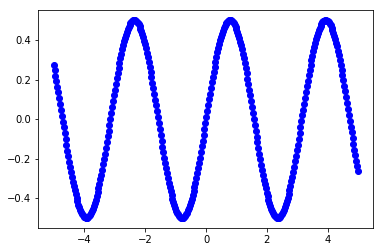

In [32]:
plt.plot(X, y, 'bo')

##### Добавим шума

In [33]:
y += np.random.normal(0.0, 0.1, size=len(X))

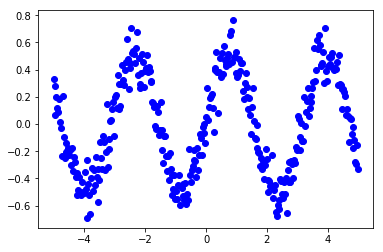

In [34]:
plt.plot(X, y, 'bo')

# Тестирование модели

In [35]:
T = 20
depth = 3

In [36]:
model1 = GBRT(depth, T, first_model_type='CM')
model2 = GBRT(depth, T, first_model_type='RF')

In [37]:
# Потому что одна фича
X = X.reshape(-1, 1)

In [38]:
model1.fit(X, y)
model2.fit(X, y)

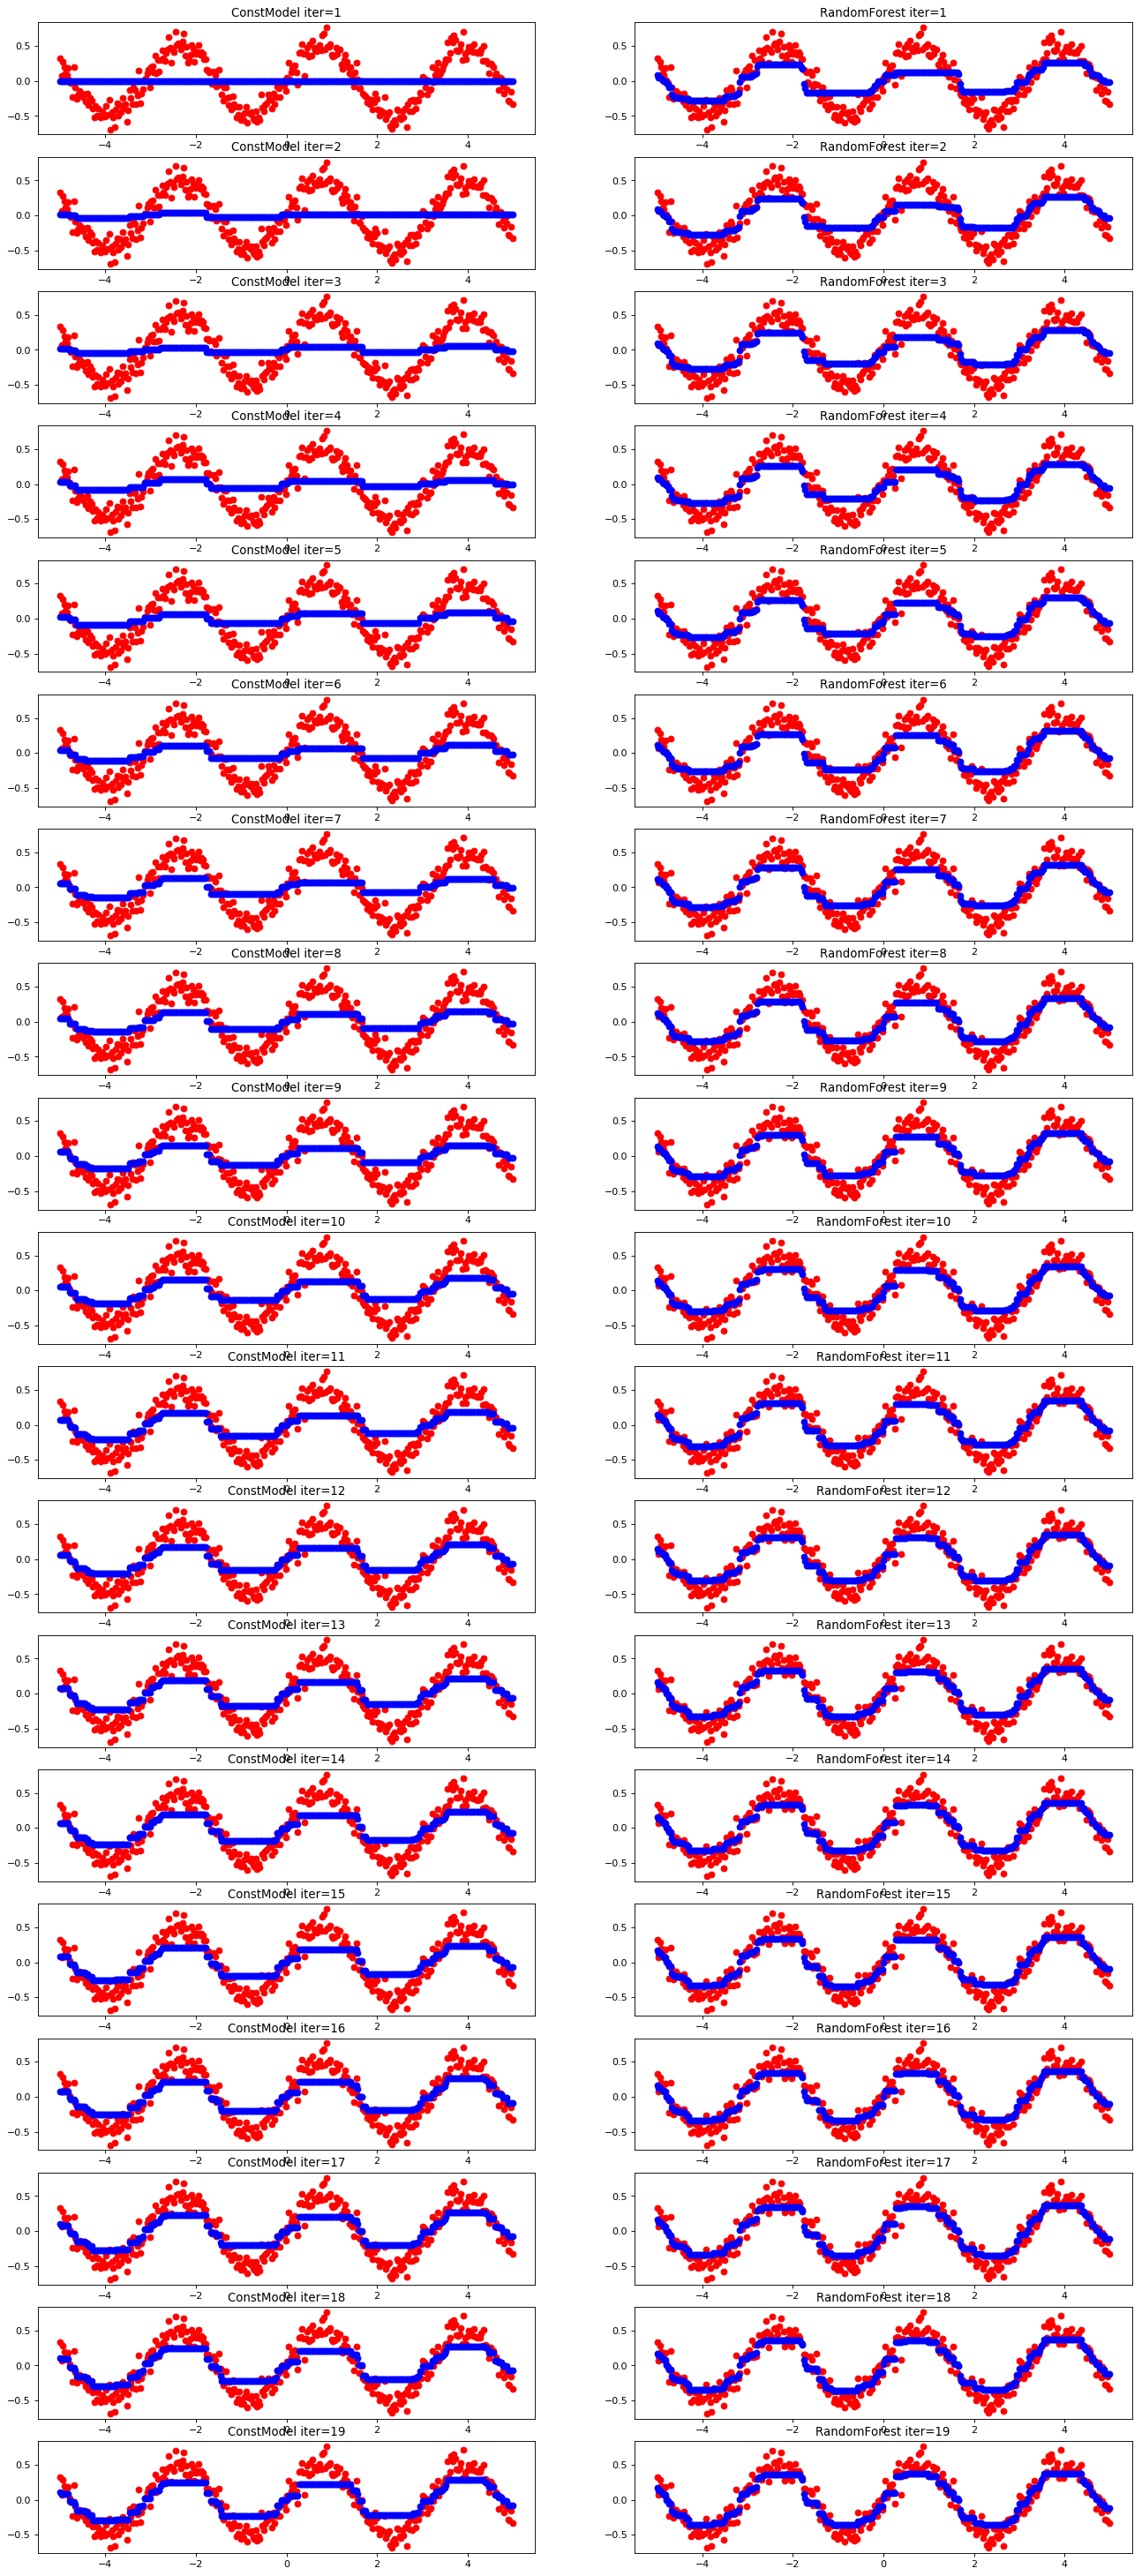

In [39]:
plt.figure(figsize=(20, 50), dpi=80)
for i in range(1, T):
    plt.subplot2grid((T,2), (i,0))
    y_pred = model1.predict(X, i)
    plt.plot(X, y, 'bo', color='red')
    plt.plot(X, y_pred, 'bo')
    plt.title(f"ConstModel iter={i}")
for i in range(1, T):
    plt.subplot2grid((T,2), (i,1))
    y_pred = model2.predict(X, i)
    plt.plot(X, y, 'bo', color='red')
    plt.plot(X, y_pred, 'bo')
    plt.title(f"RandomForest iter={i}")

# Посмотрим на ошибку в зависимости от итерации

In [40]:
loss1 = []
for i in range(1, T):
    y_pred = model1.predict(X, i)
    loss1.append(mean_absolute_error(y, y_pred))
loss2 = []
for i in range(1, T):
    y_pred = model2.predict(X, i)
    loss2.append(mean_absolute_error(y, y_pred))

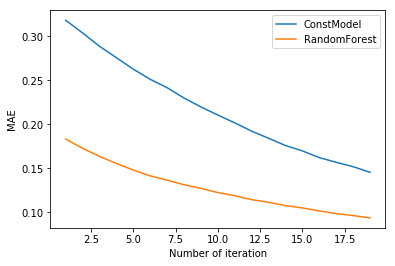

In [41]:
plt.plot(range(1, T), loss1, label="ConstModel")
plt.plot(range(1, T), loss2, label="RandomForest")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MAE")
pass

# Теперь тестирование на нормальных данных

In [42]:
with open("reg.train.txt") as fin:
    data = []
    label = [] 
    for every in fin:
        buf = every.split()
        label.append(float(buf[0]))
        features = np.array([np.nan]*245)
        for p in buf[1:-1]:
            a, b = p.split(':')
            a, b = int(a), float(b)
            features[a] = b
        data.append(features[1:])

In [43]:
X_train = np.array(data)
y_train = np.array(label)

In [44]:
with open("reg.test.txt") as fin:
    data = []
    label = [] 
    for every in fin:
        buf = every.split()
        label.append(float(buf[0]))
        features = np.array([np.nan]*245)
        for p in buf[1:-1]:
            a, b = p.split(':')
            a, b = int(a), float(b)
            features[a] = b
        data.append(features[1:])

In [45]:
X_test = np.array(data)
y_test = np.array(label)

In [46]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [47]:
X_train = np.array(df_train.fillna(value=-100.0))
X_test = np.array(df_test.fillna(value=-100.0))

In [48]:
T = 100

In [49]:
myclf = GBRT(n_estimators=T, max_depth=3, first_model_type='RF')
clf = GradientBoostingRegressor(n_estimators=T, max_depth=3, criterion='mse')

In [50]:
%time myclf.fit(X_train, y_train)

CPU times: user 20.7 s, sys: 3.04 s, total: 23.7 s
Wall time: 23.8 s


In [51]:
%time clf.fit(X_train, y_train)

CPU times: user 4.54 s, sys: 64.4 ms, total: 4.61 s
Wall time: 4.69 s


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

# График ошибки на трейне

In [52]:
loss1 = []
for y_pred in myclf.staged_predict(X_train):
    loss1.append(mean_squared_error(y_train, y_pred))
loss2 = []
for y_pred in clf.staged_predict(X_train):
    loss2.append(mean_squared_error(y_train, y_pred))

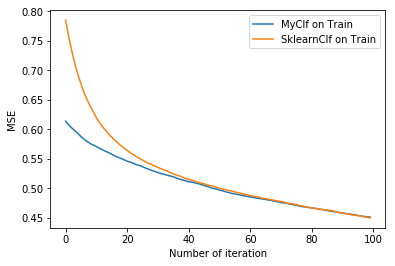

In [53]:
plt.plot(range(T), loss1, label="MyClf on Train")
plt.plot(range(T), loss2, label="SklearnClf on Train")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MSE")
pass

In [54]:
my_y_pred = myclf.predict(X_test)
y_pred = clf.predict(X_test)

In [55]:
print(f"MyClf = {mean_squared_error(y_test, my_y_pred)}\nSklearnClf = {mean_squared_error(y_test, y_pred)}")

MyClf = 0.7936997430573799
SklearnClf = 0.7912418705553845


# График ошибки на тесте

In [56]:
loss3 = []
for y_pred in myclf.staged_predict(X_test):
    loss3.append(mean_squared_error(y_test, y_pred))
loss4 = []
for y_pred in clf.staged_predict(X_test):
    loss4.append(mean_squared_error(y_test, y_pred))

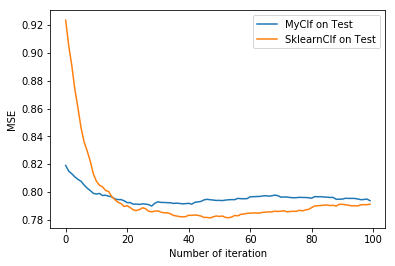

In [57]:
plt.plot(range(T), loss3, label="MyClf on Test")
plt.plot(range(T), loss4, label="SklearnClf on Test")
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel("MSE")
pass

# Дополнения

1) stage_predict (+)

2) совпадение градиентных бустингов (+)

3) RF должен быть не хуже (+)